# Introduction
Machine Learning Algorithm that takes an asset's high, low, close, open interest and volume information, trains and predicts if the future realized volatility will be higher or lower than a user defined level.  

Preprossing functions cleans and creates data frames that looks ahead to a forward period from points in time and determines if a user defined volatility threshold has been exceeded.  

This allows for a Machine Learning Algorithm to train on the data set and make predictions.   

Within this notebook, a Machine Learning clustering Decision Tree algorithm trains on a financial asset's daily market information.  Function allows user to set a range of volatilities to test after training.  It then makes predictions based on the most recent days in the data set.  

# Data
The data used here is from BarChart.com.  I download futures data that is 'daily nearby', If it has a symbol column, that which eventually needs to be removed within the function.  In order to process, the first line of the data needs to be the columns names and all the null values need to be filled in manually.  

In [1]:
import pandas as pd
import numpy as np

In [2]:
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
from sklearn.metrics import precision_recall_fscore_support

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
file = r"C:\Users\Matt\Desktop\data\subject_data.csv"

In [9]:
og = pd.read_csv(file)

In [10]:
len(og)

2049

In [11]:
def vol_convert(vol):
    rate = vol/1600
    return rate

In [12]:
start_vol = 25
end_vol = 40
step = .5
hist_period1 = 10
hist_period2 = 20
hist_period3 = 30
volume_period1 = 2
volume_period2 = 4
forward_vol_period = 20
vol_to_test = 6
rate = vol_convert(vol_to_test)

In [13]:
og.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
0,1/3/2012,E6H12,1.3047,1.3085,1.3020,1.3063,0.0000,137219,282790
1,1/4/2012,E6H12,1.3059,1.3063,1.2904,1.2944,-0.0119,216177,293235
2,1/5/2012,E6H12,1.2948,1.2952,1.2777,1.2792,-0.0152,266566,298476
3,1/6/2012,E6H12,1.2798,1.2820,1.2703,1.2729,-0.0063,227315,293406
4,1/9/2012,E6H12,1.2700,1.2791,1.2673,1.2761,0.0032,187019,291209


In [14]:
data = og.copy()

In [15]:
#process dataset ready for machine learning, add custome columns, forward vol uses mean close to close and abs change 

def process(dataframe, hist1, hist2, hist3, volume1, volume2, forward_vol_period, question_vol, cushion, 
            oi_change_period = 30):
    
    #change name of Open Interest column
    dataframe.rename(columns={'Open Interest':'OI'}, inplace=True)
    
    
    dataframe['abs_change'] = dataframe['Change'].abs() / dataframe['Close']
    
    dataframe['high_move'] = (((dataframe.High - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['low_move'] = (((dataframe.Low - data.Close.shift(1))/dataframe['Close']).abs())
    dataframe['max_move'] = dataframe[['high_move', 'low_move']].max(axis=1)
    
    dataframe['hist_max_1'] = dataframe.max_move.rolling(window=hist1).mean()
    dataframe['hist_max_2'] = dataframe.max_move.rolling(window=hist2).mean()
    dataframe['hist_max_3'] = dataframe.max_move.rolling(window=hist3).mean()
    
    dataframe['hist_change_1'] = dataframe.abs_change.rolling(window=hist1).mean()
    dataframe['hist_change_2'] = dataframe.abs_change.rolling(window=hist2).mean()
    dataframe['hist_change_3'] = dataframe.abs_change.rolling(window=hist3).mean()
    
    dataframe['avg_max_close'] = dataframe[['max_move', 'abs_change']].mean(axis=1)
    
    dataframe['hist_avgmax_1'] = dataframe.avg_max_close.rolling(window=hist1).mean()
    dataframe['hist_avgmax_2'] = dataframe.avg_max_close.rolling(window=hist2).mean()
    dataframe['hist_avgmax_3'] = dataframe.avg_max_close.rolling(window=hist3).mean()
    
    dataframe['hist_volume_1'] = dataframe.Volume.rolling(window=volume1).mean()
    dataframe['hist_volume_2'] = dataframe.Volume.rolling(window=volume2).mean()
    
    dataframe['backtothefuture'] = dataframe.avg_max_close.rolling(window=forward_vol_period).mean()
    
    dataframe['forward_avg_close_max'] = dataframe['backtothefuture'].shift(-forward_vol_period)
    
    #create column that calculates the change in Open Interest
    dataframe['oi_change'] = (((dataframe.OI - dataframe.OI.shift(oi_change_period))/dataframe['OI']).abs())
    
    
    
    
    
    
    
    
    dataframe['volatile'] = (dataframe['forward_avg_close_max'] > question_vol + cushion)
    dataframe = dataframe.applymap(lambda x: 1 if x == True else x)
    dataframe = dataframe.applymap(lambda x: 0 if x == False else x)
    #select columns
    the_columns = ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 
               'forward_avg_close_max', 'volatile', 'OI', 'oi_change' ]
    dataframe = dataframe[the_columns]
    
    return dataframe 

In [16]:
#set and process dataset 
new_data = process(data,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,forward_vol_period, rate, 0)

In [17]:
new_data.tail()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
2044,0.002893,0.002587,0.002667,167597.5,177291.00,NaN,0,612444,0.100326
2045,0.003292,0.002744,0.002778,183868.5,180334.75,NaN,0,618413,0.099970
2046,0.003462,0.002761,0.002781,195849.5,181723.50,NaN,0,622327,0.104032
2047,0.002996,0.002711,0.002616,181372.0,182620.25,NaN,0,624300,0.110067
2048,0.002825,0.002611,0.002620,181384.0,188616.75,NaN,0,625400,0.118722


In [18]:
new_data['forward_avg_close_max'].describe()

count    2029.000000
mean        0.004897
std         0.001550
min         0.001984
25%         0.003874
50%         0.004709
75%         0.005720
max         0.010881
Name: forward_avg_close_max, dtype: float64

In [19]:
new_data['volatile'].value_counts()

1    1592
0     457
Name: volatile, dtype: int64

In [20]:
new_data = new_data.dropna(how = 'any')

In [21]:
new_data.head(20)

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
30,0.005789,0.006039,0.006991,302346.0,265401.50,0.006534,1,299085,0.054483
31,0.006128,0.005926,0.006857,340869.0,293553.00,0.006541,1,294462,0.004167
32,0.006086,0.005946,0.006537,296481.0,299413.50,0.006696,1,295500,0.010071
33,0.006341,0.005935,0.006620,309263.5,325066.25,0.006417,1,287525,0.020454
34,0.005432,0.005872,0.006544,311980.5,304230.75,0.006502,1,287495,0.012918
35,0.006105,0.005990,0.006701,280398.5,294831.00,0.006251,1,280074,0.050662
36,0.006720,0.006270,0.006746,293985.0,302982.75,0.006104,1,276830,0.080349
37,0.006346,0.006135,0.006576,263755.5,272077.00,0.006158,1,272859,0.073628
38,0.006295,0.005986,0.006263,257792.0,275888.50,0.006001,1,271282,0.123370
39,0.006376,0.006229,0.006329,302586.5,283171.00,0.005645,1,275227,0.093505


In [22]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = new_data['volatile']


del new_data['volatile']
del new_data['forward_avg_close_max']

# removed 'Symbol' in process function
#del new_data['Symbol']

features = new_data

# Show the new dataset with 'Survived' removed
features.head()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,OI,oi_change
30,0.005789,0.006039,0.006991,302346.0,265401.50,299085,0.054483
31,0.006128,0.005926,0.006857,340869.0,293553.00,294462,0.004167
32,0.006086,0.005946,0.006537,296481.0,299413.50,295500,0.010071
33,0.006341,0.005935,0.006620,309263.5,325066.25,287525,0.020454
34,0.005432,0.005872,0.006544,311980.5,304230.75,287495,0.012918


In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.30, random_state=42)

In [24]:
# TODO: Define the classifier, and fit it to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.9166666666666666


In [26]:
# Training the model
model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20, min_samples_split=20)
model.fit(X_train, y_train)

# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9135096497498213
The test accuracy is 0.8666666666666667


In [27]:
def process_sample(dataframe, hist1, hist2, hist3, volume1, volume2, oi_change_period = 30):
    
    #change name of Open Interest column
    dataframe.rename(columns={'Open Interest':'OI'}, inplace=True)
    
    
    dataframe['abs_change'] = dataframe['Change'].abs() / dataframe['Close']
    
    dataframe['high_move'] = (((dataframe.High - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['low_move'] = (((dataframe.Low - data.Close.shift(1))/dataframe['Close']).abs())
    dataframe['max_move'] = dataframe[['high_move', 'low_move']].max(axis=1)
    
    dataframe['hist_max_1'] = dataframe.max_move.rolling(window=hist1).mean()
    dataframe['hist_max_2'] = dataframe.max_move.rolling(window=hist2).mean()
    dataframe['hist_max_3'] = dataframe.max_move.rolling(window=hist3).mean()
    
    dataframe['hist_change_1'] = dataframe.abs_change.rolling(window=hist1).mean()
    dataframe['hist_change_2'] = dataframe.abs_change.rolling(window=hist2).mean()
    dataframe['hist_change_3'] = dataframe.abs_change.rolling(window=hist3).mean()
    
    dataframe['avg_max_close'] = dataframe[['max_move', 'abs_change']].mean(axis=1)
    
    dataframe['hist_avgmax_1'] = dataframe.avg_max_close.rolling(window=hist1).mean()
    dataframe['hist_avgmax_2'] = dataframe.avg_max_close.rolling(window=hist2).mean()
    dataframe['hist_avgmax_3'] = dataframe.avg_max_close.rolling(window=hist3).mean()
    
    dataframe['hist_volume_1'] = dataframe.Volume.rolling(window=volume1).mean()
    dataframe['hist_volume_2'] = dataframe.Volume.rolling(window=volume2).mean()
    
        
    #create column that calculates the change in Open Interest
    dataframe['oi_change'] = (((dataframe.OI - dataframe.OI.shift(oi_change_period))/dataframe['OI']))
    

    #drop column 
    the_columns = ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 
                   'OI', 'oi_change']
    dataframe = dataframe[the_columns]
    
    dataframe = dataframe.dropna(how = 'any')
    
    #scale the dataframe
    scaler = StandardScaler().fit(dataframe)
    new_df = scaler.transform(dataframe)
    
    
    return new_df 

In [28]:
og.head()

,Date Time,Symbol,Open,High,Low,Close,Change,Volume,Open Interest
0,1/3/2012,E6H12,1.3047,1.3085,1.3020,1.3063,0.0000,137219,282790
1,1/4/2012,E6H12,1.3059,1.3063,1.2904,1.2944,-0.0119,216177,293235
2,1/5/2012,E6H12,1.2948,1.2952,1.2777,1.2792,-0.0152,266566,298476
3,1/6/2012,E6H12,1.2798,1.2820,1.2703,1.2729,-0.0063,227315,293406
4,1/9/2012,E6H12,1.2700,1.2791,1.2673,1.2761,0.0032,187019,291209


In [29]:
new_og = process_sample(og, hist_period1 ,hist_period2 ,hist_period3 , volume_period1, volume_period2)

In [30]:
new_og

array([[ 0.52576874,  0.74458027,  1.42050097, ...,  0.4029205 ,
        -0.90131372,  0.39446497],
       [ 0.72158512,  0.67119983,  1.3290363 , ...,  0.75162215,
        -0.94274294,  0.0216884 ],
       [ 0.69734714,  0.68451653,  1.11223089, ...,  0.82421388,
        -0.93344085, -0.08379686],
       ...,
       [-0.81987631, -1.37446744, -1.43761455, ..., -0.63356627,
         1.99543352,  0.76156178],
       [-1.08894249, -1.40683557, -1.54987184, ..., -0.62245858,
         2.01311464,  0.80627452],
       [-1.18786313, -1.47187163, -1.54729565, ..., -0.54818227,
         2.02297234,  0.87039805]])

In [31]:
new_og[-1]

array([-1.18786313, -1.47187163, -1.54729565, -0.55477835, -0.54818227,
        2.02297234,  0.87039805])

In [32]:
# delete all non-floats

#del new_og['Date Time']
#del new_og['Symbol']


In [34]:
last_date = new_og[-1]
last_date

array([-1.18786313, -1.47187163, -1.54729565, -0.55477835, -0.54818227,
        2.02297234,  0.87039805])

In [35]:
#one_sample = [new_og.iloc[last_date,:]] 

In [36]:
model.predict([last_date])

array([0], dtype=int64)

In [37]:
def tail_vol(period, dataframe):
    rate = dataframe['avg_max_close'].tail(period).mean()
    vol = round((rate*100*16),2)
    
    return vol

In [38]:
#tail_vol(20, new_og)

In [40]:
experiment_df = pd.read_csv(file)

experiment = process(experiment_df,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,
                        forward_vol_period, rate, 0)

In [41]:
len(experiment)

2049

In [42]:
pd.set_option('display.max_columns', 999)

In [43]:
experiment.head()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
0,NaN,NaN,NaN,NaN,NaN,0.007592,1,282790,NaN
1,NaN,NaN,NaN,176698.0,NaN,0.007221,1,293235,NaN
2,NaN,NaN,NaN,241371.5,NaN,0.006763,1,298476,NaN
3,NaN,NaN,NaN,246940.5,211819.25,0.006760,1,293406,NaN
4,NaN,NaN,NaN,207167.0,224269.25,0.007100,1,291209,NaN


In [69]:
#select columns to keep, create list to reduce variables
the_columns = ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 
               'forward_avg_close_max', 'volatile', 'OI', 'oi_change' ]

In [70]:
experiment = experiment[the_columns]

In [46]:
experiment.describe()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
count,2040.000000,2030.000000,2020.000000,2048.000000,2046.000000,2029.000000,2049.000000,2049.000000,2019.000000
mean,0.004901,0.004898,0.004900,233645.528076,233683.103006,0.004897,0.776964,398181.360176,0.102413
std,0.001736,0.001550,0.001474,92562.260239,80650.400544,0.001550,0.416384,111463.397627,0.087952
min,0.001721,0.001984,0.002096,30277.500000,69814.500000,0.001984,0.000000,185313.000000,0.000333
25%,0.003739,0.003875,0.003921,172799.375000,178572.875000,0.003874,1.000000,300962.000000,0.039935
50%,0.004630,0.004710,0.004711,217409.000000,221077.875000,0.004709,1.000000,408853.000000,0.075405
75%,0.005753,0.005720,0.005683,268583.750000,268934.625000,0.005720,1.000000,492662.000000,0.142225
max,0.014023,0.010881,0.010173,831893.000000,644397.750000,0.010881,1.000000,666250.000000,0.706236


In [52]:
def find_vol(dataframe, start_vol, end_vol, step, hist_period1, hist_period2, hist_period3, 
             volume_period1, volume_period2, forward_vol_period):
    vol = start_vol
    while vol < end_vol: 
        answer = 1 
        rate = vol_convert(vol)
        beg_frame = dataframe.copy()
        
        frame = process(dataframe,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,
                        forward_vol_period, rate, 0)
   
    
        frame = frame.dropna(how = 'any')
    
        outcomes = frame['volatile']
        features = frame

        del features['volatile']
        del features['forward_avg_close_max']
        
        #scale the data
        scaler = StandardScaler().fit(features)
        rescaledX = scaler.transform(features)
        
        #split
        X_train, X_test, y_train, y_test = train_test_split(rescaledX, outcomes, test_size=0.30, random_state=42)
        # Training the model
        model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20, min_samples_split=20)
        model.fit(X_train, y_train)

        # Making predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculating accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        the_f1 = f1_score(y_test, y_test_pred)
        
   
    
        original_data = process_sample(beg_frame, hist_period1 ,hist_period2 ,hist_period3 , volume_period1, volume_period2)
        #original_data = original_data.dropna(how = 'any')
        
        #del original_data['Date Time']
        last_row = original_data[-1]
        one_sample = last_row
    
        answer = model.predict([one_sample])
        answer = answer[0]
        
        #send feature columns to a list
        cols = features.columns.tolist()
        
        
        print(vol)
        print(answer)
        print('The training accuracy is', train_accuracy)
        print('The test accuracy is', test_accuracy)
        print('The precision is', precision)
        print('The recall is', recall)
        print('The F1 is', the_f1 )
        
        
        print('The number of days', len(outcomes))
        print('The percentage of volatile days', ((outcomes == 1).sum()) / len(outcomes))
        
        print('The feauture columns are', cols)

        print('The independent variable for prediction is', one_sample)
        
        
        #print(frame.head(1))
    
        #if answer == 0:
            #break

        vol = vol + step
    


In [65]:
fv_dataframe = pd.read_csv(file)
vol = 4.75
start_vol = 3.5
end_vol = 5.5
step = .10
hist_period1 = 5
hist_period2 = 10
hist_period3 = 15
volume_period1 = 4
volume_period2 = 8
forward_vol_period = 30
rate = vol_convert(vol)

In [66]:
check = process(fv_dataframe,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,
                        forward_vol_period, rate, 0)

In [67]:
check.head()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
0,NaN,NaN,NaN,NaN,NaN,0.006991,1,282790,NaN
1,NaN,NaN,NaN,NaN,NaN,0.006857,1,293235,NaN
2,NaN,NaN,NaN,NaN,NaN,0.006537,1,298476,NaN
3,NaN,NaN,NaN,211819.25,NaN,0.006620,1,293406,NaN
4,0.006572,NaN,NaN,224269.25,NaN,0.006544,1,291209,NaN


In [68]:
find_vol(fv_dataframe, start_vol, end_vol, step, hist_period1, hist_period2, hist_period3, 
         volume_period1, volume_period2, forward_vol_period)

3.5
1
The training accuracy is 0.9978448275862069
The test accuracy is 0.9966499162479062
The precision is 0.9966499162479062
The recall is 1.0
The F1 is 0.9983221476510068
The number of days 1989
The percentage of volatile days 0.9974861739567622
The feauture columns are ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 'OI', 'oi_change']
The independent variable for prediction is [-1.18775317 -1.18786313 -1.33393782 -0.54818227 -0.71978083  2.02297234
  0.87039805]
3.6
1
The training accuracy is 0.9942528735632183
The test accuracy is 0.9899497487437185
The precision is 0.9899497487437185
The recall is 1.0
The F1 is 0.9949494949494949
The number of days 1989
The percentage of volatile days 0.9929612870789342
The feauture columns are ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 'OI', 'oi_change']
The independent variable for prediction is [-1.18775317 -1.18786313 -1.33393782 -0.54818227 -0.71978083  2.0229723

5.099999999999996
1
The training accuracy is 0.9511494252873564
The test accuracy is 0.916247906197655
The precision is 0.9208103130755064
The recall is 0.9861932938856016
The F1 is 0.9523809523809524
The number of days 1989
The percentage of volatile days 0.8828557063851181
The feauture columns are ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 'OI', 'oi_change']
The independent variable for prediction is [-1.18775317 -1.18786313 -1.33393782 -0.54818227 -0.71978083  2.02297234
  0.87039805]
5.199999999999996
1
The training accuracy is 0.9439655172413793
The test accuracy is 0.9095477386934674
The precision is 0.9310344827586207
The recall is 0.9642857142857143
The F1 is 0.9473684210526316
The number of days 1989
The percentage of volatile days 0.8758169934640523
The feauture columns are ['hist_avgmax_1', 'hist_avgmax_2', 'hist_avgmax_3', 'hist_volume_1', 'hist_volume_2', 'OI', 'oi_change']
The independent variable for prediction is [-1.18775317 -

In [71]:
def tail_vol(period, dataframe):
    rate = dataframe['avg_max_close'].tail(period).mean()
    vol = round((rate*100*16),2)
    
    return vol

In [72]:
analyze = process(og,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,forward_vol_period, rate, 0)

In [74]:
analyze.tail()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
2044,0.002937,0.002893,0.002670,177291.00,183901.375,NaN,0,612444,0.100326
2045,0.003099,0.003292,0.002931,180334.75,179170.875,NaN,0,618413,0.099970
2046,0.003165,0.003462,0.002822,181723.50,181083.000,NaN,0,622327,0.104032
2047,0.002753,0.002996,0.002697,182620.25,183138.250,NaN,0,624300,0.110067
2048,0.002505,0.002825,0.002726,188616.75,182953.875,NaN,0,625400,0.118722


In [75]:
analyze = analyze.dropna(how = 'any')

In [76]:
analyze.describe()

,hist_avgmax_1,hist_avgmax_2,hist_avgmax_3,hist_volume_1,hist_volume_2,forward_avg_close_max,volatile,OI,oi_change
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.004909,0.004912,0.004916,233769.100553,233918.412770,0.004877,0.903972,396789.600804,0.102861
std,0.001993,0.001722,0.001607,81005.264189,69584.282119,0.001473,0.294704,109929.324991,0.088422
min,0.001474,0.001721,0.001863,69814.500000,90810.500000,0.002096,0.000000,185313.000000,0.000333
25%,0.003558,0.003765,0.003876,178732.250000,183917.375000,0.003907,1.000000,302459.000000,0.039981
50%,0.004555,0.004635,0.004715,221125.250000,221739.875000,0.004695,1.000000,408853.000000,0.075356
75%,0.005846,0.005736,0.005692,268354.250000,271776.125000,0.005633,1.000000,488059.000000,0.143712
max,0.015512,0.014023,0.012010,644397.750000,483077.375000,0.010173,1.000000,666250.000000,0.706236


In [78]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

import seaborn as sns

<function matplotlib.pyplot.show(*args, **kw)>

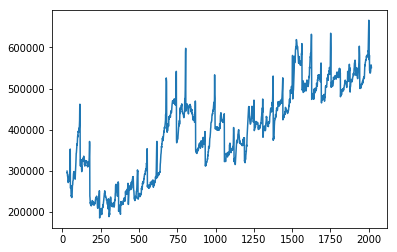

In [80]:
oi = analyze['OI']
plt.plot(oi)
plt.show

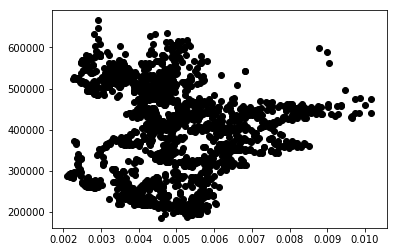

In [85]:
oi = analyze['OI']
vol = analyze['forward_avg_close_max']
plt.plot(vol, oi, 'o', color='black');

# Open Interest

Including open Interest does not seem to improve the predictability if the open interest is just rising over time.  Would exclude that variable and use other risk predictor versions.  